## fit GLMs on fish data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import time
from glob import glob
os.chdir('/Users/claireeverett/Desktop/Process_input/scripts/')
from daart.data import load_feature_csv, load_label_csv, split_trials
from daart.eval import get_precision_recall

from IPython.display import Audio



### helper functions

In [3]:
def expand_with_lags(data, n_lags=0):
    """Construct a design matrix with lags for a regression model.
    
    Parameters
    ----------
    data : array-like
        shape of (n_samples, n_features)
    n_lags : int
        number of lags *preceding* and *proceeding* each time bin
        
    Returns
    -------
    array-like
    
    """
    data_w_shifts = []
    #for shift in np.arange(-n_lags, n_lags + 1): # if. you want lag in both directions
    for shift in np.arange(-n_lags, 1): # lag leading up to predicted event
        if shift == 0:
            data_tmp = data.copy()
        else:
            data_tmp = np.roll(data, shift=shift, axis=0)
        if shift > 0:
            data_tmp[:shift] = 0
        elif shift < 0:
            data_tmp[shift:] = 0
        data_w_shifts.append(data_tmp)
    return np.hstack(data_w_shifts)


def logistic_regression_search(
        features_train, targets_train, features_val=None, targets_val=None, l2_reg_list=[0],
        max_iter=5000, verbose=True
):
    """Fit a series of logistic regression binary classifiers.

    Parameters
    ----------
    features_train : np.ndarray
        shape (n_samples, n_features)
    targets_train : np.ndarray
        shape (n_samples,)
    features_val : np.ndarray, optional
        shape (n_samples, n_features); if None, results dict will contain evaluation on train data
    targets_val : np.ndarray, optional
        shape (n_samples,); if None, results dict will contain evaluation on train data
    l2_reg_list : list of int, optional
        l2 regularization parameter on weights
    max_iter : int, optional
        max number of iterations
    verbose : bool, optional
        print info along the way

    Returns
    -------
    tuple
        list: models
        pd.DataFrame: eval results

    """
    from sklearn.linear_model import LogisticRegression
    metrics = []
    models = []
    index = 0
    for l2_reg in l2_reg_list:

        model = LogisticRegression(
            penalty='l2', max_iter=max_iter, C=l2_reg, class_weight='balanced')
        if verbose:
            print(model)
        t_beg = time.time()
        model.fit(features_train, targets_train)
        models.append(model)
        t_end = time.time()
        if verbose:
            print('fitting time: %1.2f sec' % (t_end - t_beg))

        if features_val is not None and targets_val is not None:
            preds = model.predict(features_val)
            results = get_precision_recall(targets_val, preds, background=None)
        else:
            print('no validation data; evaluating on train data')
            preds = model.predict(features_train)
            results = get_precision_recall(targets_train, preds, background=None)

        metrics.append(pd.DataFrame({
            'l2_reg': l2_reg,
            'precision': np.mean(results['precision']),
            'recall': np.mean(results['recall']),
            'f1': np.mean(results['f1']),
        }, index=[index]))
        index += 1

    metrics = pd.concat(metrics)
    return models, metrics

### fit models

In [4]:
# ------------------------------------
# user options
# ------------------------------------
# data split fractions
train_frac = 0.8
val_frac = 0.1
test_frac = 0.1

# number of consecutive time points for chunks of data
chunk_len = 500

# number of pre/post lags in features to use for predicting target
#n_lags = 15

# define hyperparameters to loop over
l2_reg_list = [1e-3, 1e-2, 1e-1, 1e-6, 1e-7]

# filepath_labels = '/media/mattw/behavior/results/daart/fish/multi-6/dtcn/ternary3/version_0/6.1.1L_states.npy'
filepath_labels_dir = '/Users/claireeverett/Desktop/demo_daart/GLM/data/manual/left_new/'
filepath_labels = sorted(glob(os.path.join(filepath_labels_dir,'*.csv')))

filepath_features_dir = '/Users/claireeverett/Desktop/demo_daart/GLM/data/basefeatures/right_new/'
filepath_features = sorted(glob(os.path.join(filepath_features_dir,'*.csv')))

# ------------------------------------
# load data
# ------------------------------------
results_list = []
for i in np.arange(len(filepath_labels)):
    #for p in np.arange(40, 100, 1): 
    n_lags = 65
    #for n in np.arange(100, )
    # store data chunks
    features_dict = {'train': [], 'val': [], 'test': []}
    targets_dict = {'train': [], 'val': [], 'test': []}

    # load discrete behavior from one fish
    targets, target_names = load_label_csv(filepath_labels[i])
    print('targets:')
    for t, target_name in enumerate(target_names):
        print('    %s: %i' % (target_name, np.sum(targets[:, t])))
    print()
    # turn one-hot vector into a dense representation
    targets = np.argmax(targets, axis=1)  

    # load features from the paired fish
    features, feature_names = load_feature_csv(filepath_features[i])
    print('feature names: {}'.format(feature_names))
    # expand features to include lags
    features_w_lags = expand_with_lags(features, n_lags=n_lags)

    # ------------------------------------
    # break data into train/val/test folds
    # ------------------------------------
    # get train/val/test indices wrt chunks
    assert (train_frac + val_frac + test_frac) == 1.0
    n_chunks = targets.shape[0] // chunk_len
    idxs_xv_chunk = split_trials(
        n_chunks, rng_seed=0, train_tr=int(train_frac*10), val_tr=int(val_frac*10), test_tr=int(test_frac*10), gap_tr=0)

    # get train/val/test indices wrt time points
    idxs_xv = {}
    for dtype, idxs_ in idxs_xv_chunk.items():
        tmp = [np.arange(c * chunk_len, (c + 1) * chunk_len) for c in idxs_]
        idxs_xv[dtype] = np.sort(np.concatenate(tmp))

        features_dict[dtype] = features_w_lags[idxs_xv[dtype]]
        targets_dict[dtype] = targets[idxs_xv[dtype]]

    #l2_reg_list = [1e-5, 1e-6, 1e-7]

    # fit models
    models, metrics_df = logistic_regression_search(
        features_dict['train'], targets_dict['train'], 
        features_dict['val'], targets_dict['val'], 
        l2_reg_list,
    )

    # get best model
    idxs_max = metrics_df.f1.idxmax()
    model_best  = models[idxs_max]

    # evaluate best model on test data
    preds = model_best.predict(features_dict['test'])
    results = get_precision_recall(targets_dict['test'], preds, background=None)
    results_list.append(['feat' + os.path.basename(filepath_features[i]).split('new')[0] + '_targ' + os.path.basename(filepath_labels[i]).split('_')[0],results])


sound_file = '/Users/claireeverett/Desktop/demo_adaart/GLM/data/Bing Bong Sound Effects.mp3'
Audio(sound_file, autoplay=True)

targets:
    background: 30541
    comb_flare: 41459

feature names: ['operculum', 'orientation', 'movement_speed', 'turning_angle', 'head_x', 'head_y', 'centroid_x', 'centroid_y', 'tail_x', 'tail_y', 'tail_angle', 'tail_dev', 'full_flaring', 'half_flaring', 'elevation']
LogisticRegression(C=0.001, class_weight='balanced', max_iter=5000)


/Users/claireeverett/opt/anaconda3/envs/daart/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fitting time: 234.88 sec
LogisticRegression(C=0.01, class_weight='balanced', max_iter=5000)


/Users/claireeverett/opt/anaconda3/envs/daart/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fitting time: 219.50 sec
LogisticRegression(C=0.1, class_weight='balanced', max_iter=5000)


/Users/claireeverett/opt/anaconda3/envs/daart/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


fitting time: 216.80 sec
LogisticRegression(C=1e-06, class_weight='balanced', max_iter=5000)
fitting time: 18.01 sec
LogisticRegression(C=1e-07, class_weight='balanced', max_iter=5000)
fitting time: 5.72 sec


In [5]:
results_list


[['feat1.3.1R_withside.csv_targ1.3.1L',
  {'precision': array([0.67932489, 0.73676612]),
   'recall': array([0.63846662, 0.7705083 ]),
   'f1': array([0.65826235, 0.75325953])}]]

In [6]:
results_new = pd.DataFrame(results_list)

In [7]:
results_new.to_csv('/Users/claireeverett/Desktop/demo_daart/GLM/lag_analysis_2state.csv')

In [8]:
np.arange(10, 20, 1)

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19])

In [9]:
metrics_df

,l2_reg,precision,recall,f1
0,1.000000e-03,0.697837,0.706621,0.700652
1,1.000000e-02,0.699908,0.708784,0.702763
2,1.000000e-01,0.698277,0.708065,0.701118
3,1.000000e-06,0.698340,0.705424,0.700937
4,1.000000e-07,0.700286,0.710995,0.703107


In [10]:
dtype = 'train'
preds = model_best.predict(features_dict[dtype])
results = get_precision_recall(targets_dict[dtype], preds, background=None)
print(results)

{'precision': array([0.64380222, 0.76686261]), 'recall': array([0.71891892, 0.69919758]), 'f1': array([0.67929025, 0.73146858])}


In [11]:
dtype = 'val'
preds = model_best.predict(features_dict[dtype])
results = get_precision_recall(targets_dict[dtype], preds, background=None)
print(results)

{'precision': array([0.59530293, 0.80526834]), 'recall': array([0.68858268, 0.73340807]), 'f1': array([0.63855422, 0.76766017])}


In [12]:
dtype = 'test'
preds = model_best.predict(features_dict[dtype])
results = get_precision_recall(targets_dict[dtype], preds, background=None)
print(results)

{'precision': array([0.67932489, 0.73676612]), 'recall': array([0.63846662, 0.7705083 ]), 'f1': array([0.65826235, 0.75325953])}


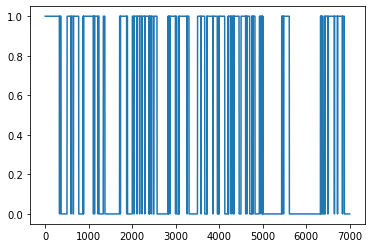

In [13]:
plt.plot(targets_dict['test'])

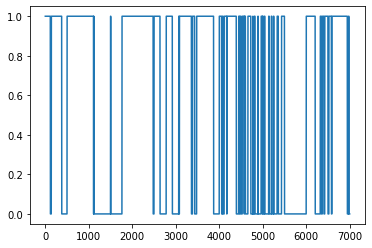

In [14]:
plt.plot(preds)

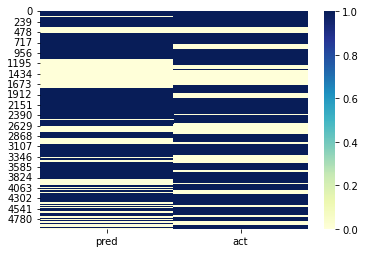

In [139]:
Compare = pd.DataFrame(preds[:5000], columns = ['pred'])
Compare['act'] = targets_dict['test'][:5000]
sns.heatmap(Compare, cmap="YlGnBu")
plt.savefig('/Users/claireeverett/Desktop/demo_daart/GLM/prediction.pdf')

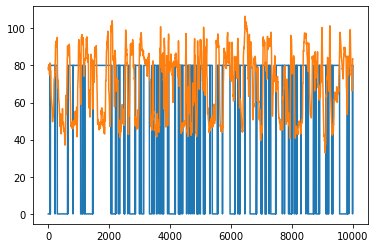

In [85]:
plt.plot(targets[20000:30000]*80)
plt.aplot(features[:, 0][20000:30000])

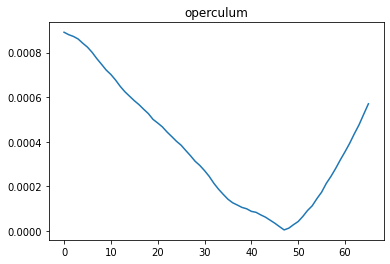

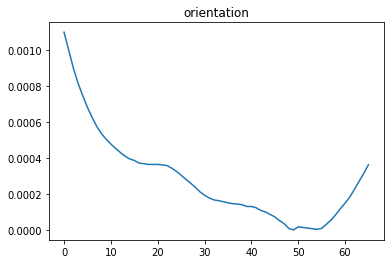

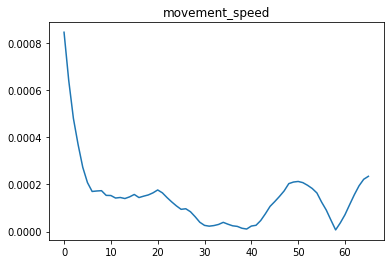

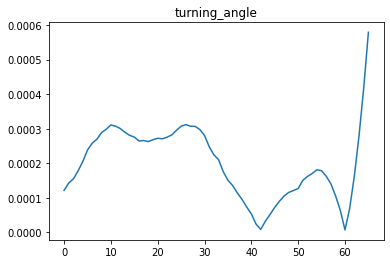

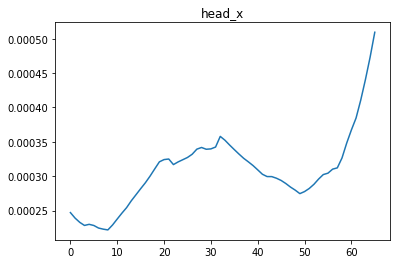

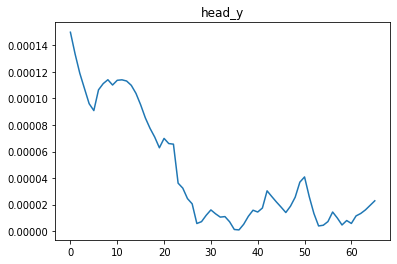

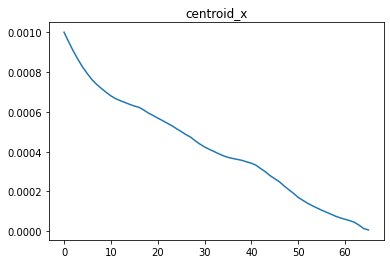

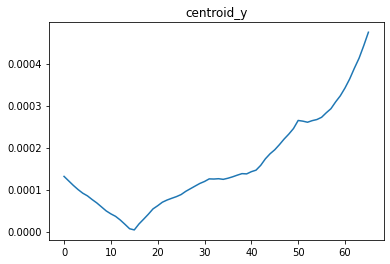

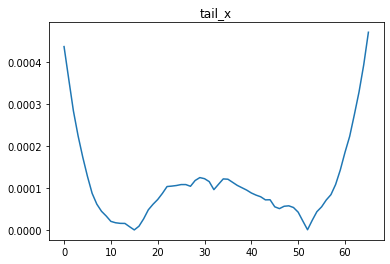

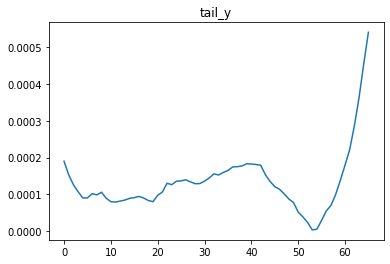

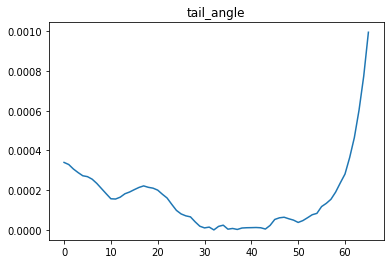

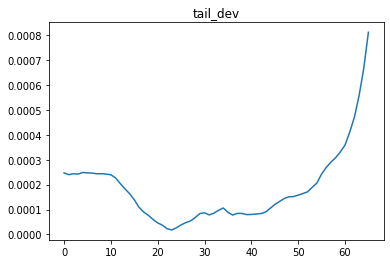

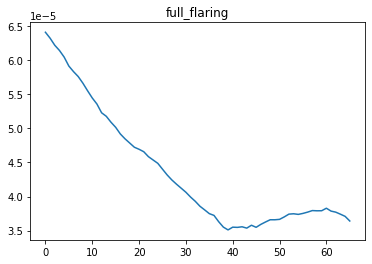

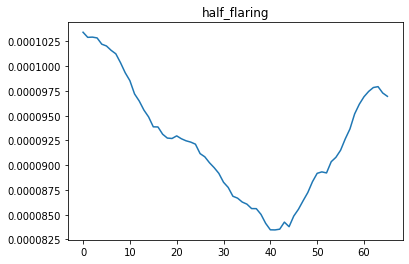

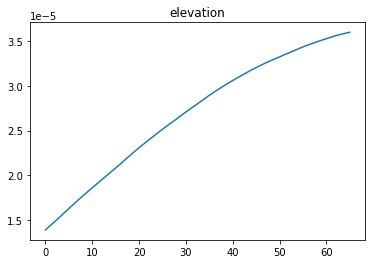

In [106]:
# make a dataframe of the normalized weights for each feature (NEW WAY)
feature_weights = pd.DataFrame(model_best.coef_)
#feature_weights.to_csv('/Users/claireeverett/Desktop/demo_daart/GLM/feature_weights_65.csv')
n_range = np.arange(15)


delay_list = []
ans_list = []
for p in np.arange(len(n_range)):
    oper_test = []
    for i in np.arange(n_lags + 1):
        for n in [n_range[p] + (i * len(n_range))]:
            oper_test.append(abs(feature_weights.values[0][n]))
    
    plt.plot(oper_test)
    plt.title(str(feature_names[p]))
    delay_list.append(str(n_lags+1 - int(np.where(oper_test == np.max(oper_test))[0])))
    ans_list.append(np.max(oper_test))
    plt.show()

0.0008909988877193601 66


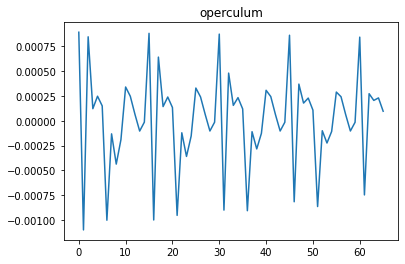

0.0008242277680635078 57


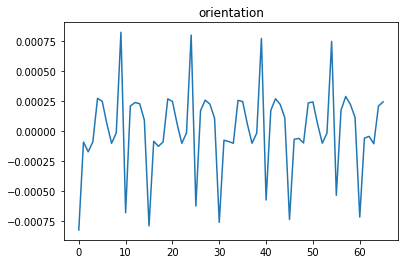

0.0007215438357945014 63


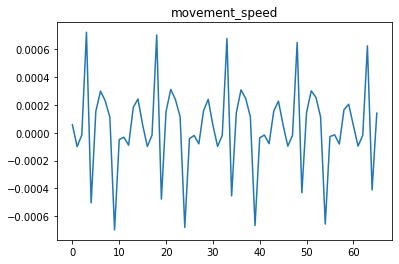

0.0006042218253964591 54


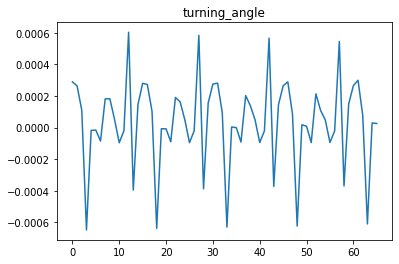

0.0005264436613742872 60


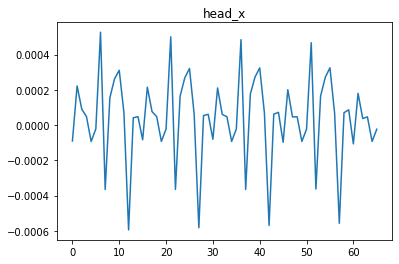

0.0004437643495021796 66


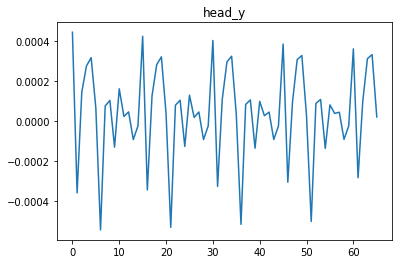

0.00034183482915123265 38


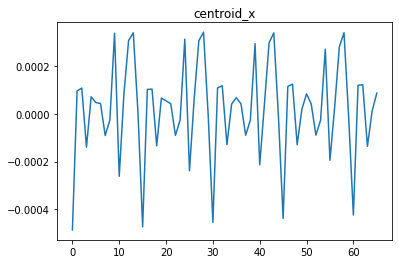

0.000357942280383294 44


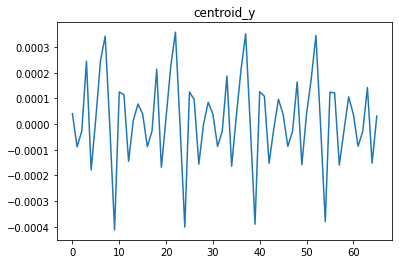

0.000338731574067705 65


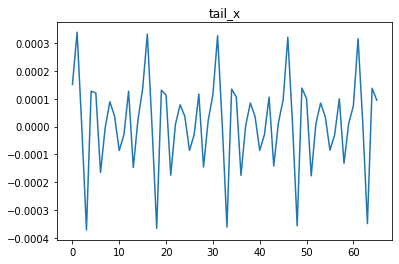

0.0003092964476637039 56


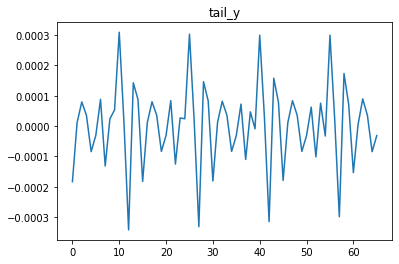

0.0002971313232668614 62


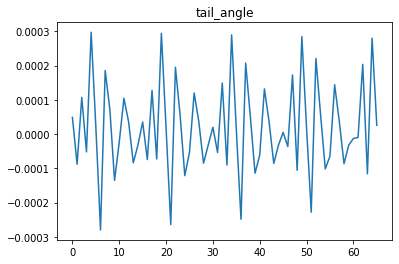

0.00028826442091941303 8


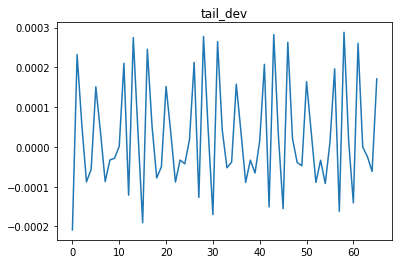

0.00031033898125345117 14


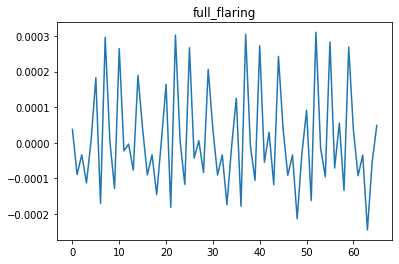

0.0003846188233094065 5


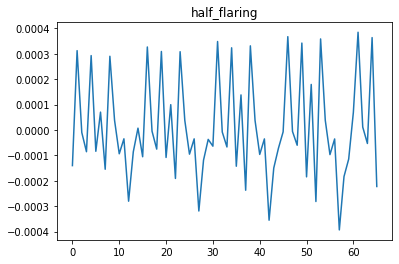

0.0008111271749974495 4


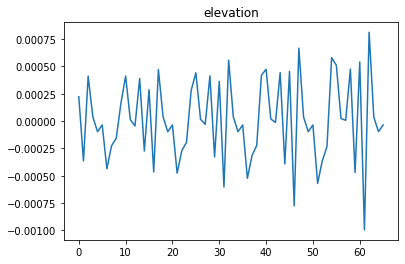

In [114]:
# make a dataframe of the normalized weights for each feature (OLD WAY)
feature_weights = pd.DataFrame(model_best.coef_)

counter = 0
ans_list = []
delay_list = []

# graph the feature weights, and get the max weight at which delay
for i in range(0, len(feature_weights.columns), 66):
    ans = feature_weights.values[0][i:i + 66]
    ans_list.append(np.max(ans))
    delay_list.append(str(66 - int(np.where(ans == np.max(ans))[0])))
    print(np.max(ans), str(66 - int(np.where(ans == np.max(ans))[0])))
    plt.plot(ans)
    plt.title(feature_names[counter])
    plt.show()
    counter = counter + 1

In [115]:
delay_list

['66',
 '57',
 '63',
 '54',
 '60',
 '66',
 '38',
 '44',
 '65',
 '56',
 '62',
 '8',
 '14',
 '5',
 '4']

In [116]:
# make the list of feature + delay, for column name    
test = pd.DataFrame(index = np.arange(len(feature_names)), columns = ['feature', 'delay', 'combo'])
test['feature'][0:len(test)] = feature_names
test['delay'][0:len(test)] = delay_list
test['combo'] = test['feature'] + test['delay']
column_names= list(test['combo'])

In [117]:
# make dataframe 
max_df = pd.DataFrame(index = np.arange(1), columns = column_names)
counter = 0
for i in np.arange(len(feature_names)):
    max_df[column_names[counter]].values[0] = ans_list[counter]
    counter = counter + 1
    
# make normalized dataframe
new_val_list = []
for value in max_df.values[0]:
    new_val = value * (1/max_df.values[0].sum())
    new_val_list.append(new_val)
    
norm_df = pd.DataFrame(index = np.arange(1), columns = column_names)
norm_df.values[0] = new_val_list
print(norm_df)

  operculum66 orientation57 movement_speed63 turning_angle54  head_x60  \
0    0.119589      0.110627        0.0968452       0.0810983  0.070659   

    head_y66 centroid_x38 centroid_y44   tail_x65   tail_y56 tail_angle62  \
0  0.0595618    0.0458809    0.0480428  0.0454644  0.0415136    0.0398808   

   tail_dev8 full_flaring14 half_flaring5 elevation4  
0  0.0386907      0.0416535     0.0516233   0.108869  


In [129]:
delay list

SyntaxError: invalid syntax (<ipython-input-129-a6be59aa0966>, line 1)

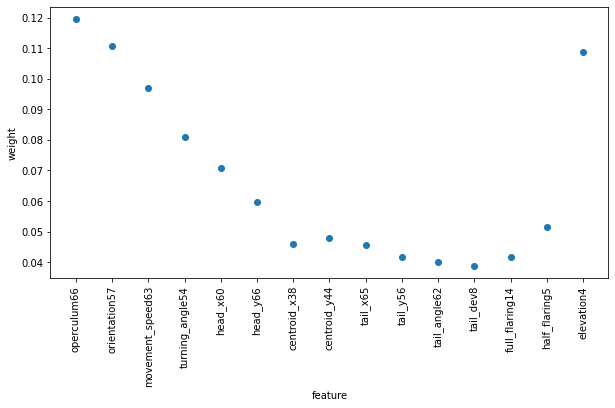

In [119]:
# plot the weight of features with optimized amnt of delay

fig, ax = plt.subplots(1,1,figsize=(10,5) )
plt.plot(norm_df.values[0], 'o')
x_label_list = list(norm_df.columns)
ax.set_xticks(np.arange(len(x_label_list)))
ax.set_xticklabels(x_label_list)
plt.ylabel('weight')
plt.xlabel('feature')
plt.xticks(rotation = 90)
plt.savefig('/Users/claireeverett/Desktop/demo_daart/GLM/feature_weights.pdf')

/Users/claireeverett/opt/anaconda3/envs/daart/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/claireeverett/opt/anaconda3/envs/daart/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  if __name__ == '__main__':


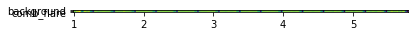

In [40]:
fig, ax = plt.subplots(1,1)

img = ax.imshow(feature_weights)

x_label_list = list(feature_weights.columns)
y_label_list =  target_names

ax.set_xticklabels(x_label_list)
ax.set_yticklabels(y_label_list)


plt.show()

,operculum,orientation,movement_speed,turning_angle,head_x,head_y,centroid_x,centroid_y,tail_x,tail_y,tail_angle,tail_dev,oper_angle_avg,oper_dist_avg
0,-0.010722,0.005494,-0.001654,-0.000541,-0.010078,-0.004943,0.018076,0.001834,-0.001780,-0.001877,0.004373,-0.005631,0.021150,-0.037069
1,0.001118,0.000876,-0.002493,0.001487,0.022006,0.002844,-0.029401,-0.000493,0.006999,0.000142,-0.002121,0.007367,-0.025869,0.051172
2,0.009604,-0.006370,0.004147,-0.000945,-0.011928,0.002099,0.011325,-0.001341,-0.005219,0.001735,-0.002251,-0.001736,0.004719,-0.014103
